In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from collections import defaultdict, Counter
from tqdm import tqdm
import collections
import pickle
import re
import math

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, make_scorer, classification_report
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn import svm
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import make_scorer, f1_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

import joblib

f

In [2]:
#load pickled data
with open('train_df.pickle', 'rb') as f:
    train_df = pickle.load(f)

In [3]:
#load pickled data
with open('test_df.pickle', 'rb') as f:
    test_df = pickle.load(f)

In [7]:
#keep lemmatized sentence for text transformations
def df_copy_text(df):
    X = df.copy()
    X = X.drop(['original_text','clean_text','tokens','bert_embeddings','lemmatized_text'],axis=1)
    if 'id' in df.columns:
        X = X.drop('id',axis=1)
    y = X.pop('label')
    return X, y


X, y = df_copy_text(train_df)
X_test, _ = df_copy_text(test_df)

In [ ]:
#load pickled data
with open('results15df.pkl', 'rb') as f:
    results_df = pickle.load(f)

In [7]:
results_df['mean_score'] = results_df['cv_scores'].apply(np.mean)
results_df['standard_error'] = results_df['cv_scores'].apply(lambda x: np.std(x) / np.sqrt(len(x)))
results_df.head()

In [18]:
X.columns

Index(['num_words', 'num_characters', 'num_unique_words',
       'ratio_unique_total_words', 'num_long_words', 'syllable_count',
       'avg_syllables_per_word', 'lexical_diversity', 'type_toke_ration',
       'multiple_meanings_count', 'numeric_only', 'only_punctuation',
       'punctuation_count', 'pos_NN_count', 'pos_VB_count', 'pos_JJ_count',
       'pos_RB_count', 'flesch_reading_ease_category', 'gunning_fog_category',
       'smog_index_category', 'dale_chall', 'high_aoa', 'low_aoa',
       'concrete_count', 'non_concrete_count', 'mean_concreteness',
       'mean_subtlex_us_frequency', 'parse_tree_depth', 'num_clauses',
       'num_noun_chunks', 'num_named_entities', 'avg_word_len', 'num_nsubj',
       'punctuation_complexity', 'unique_tenses', 'unique_named_entity_types',
       'avg_dependency_distance'],
      dtype='object')

# Feature Importance

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42,stratify=y)

In [11]:

# Create scorer, scaler and classifier
scorer = make_scorer(f1_score, average='macro')
scaler = StandardScaler()
clf = XGBClassifier(gamma=0, n_estimators=775, max_depth=15, eval_metric="logloss")

# Create the pipeline
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])

# Fit the pipeline to the training data
pipeline.fit(X_train, y_train)

# Generate predictions
y_pred = pipeline.predict(X_test)

# Convert the predictions and actual values to a pandas DataFrame
df = pd.DataFrame({'actual': y_test, 'predicted': y_pred})

# Find the indexes of the examples that were incorrectly classified
incorrect = df[df['actual'] != df['predicted']]

# Get the first 3 examples
incorrect_examples = incorrect.head(3)

# Print the incorrect examples
print(incorrect_examples)

# Get the indices of the incorrect examples
incorrect_indices = incorrect_examples.index

# Print the indices of the incorrectly classified examples
print(f"The indices of the incorrectly classified examples are: {incorrect_indices.tolist()}")

# Use these indices to get the corresponding feature values from the original DataFrame
incorrect_features = X.loc[incorrect_indices]

# Print the features of the incorrectly classified examples
print(incorrect_features)


        actual  predicted
182810       1          0
176814       1          0
242876       0          1
The indices of the incorrectly classified examples are: [182810, 176814, 242876]
        num_words  num_characters  num_unique_words  ratio_unique_total_words  \
182810         15              86                14                  0.933333   
176814         13              66                13                  1.000000   
242876         23             110                20                  0.869565   

        num_long_words  syllable_count  avg_syllables_per_word  \
182810               5              23                1.533333   
176814               2              17                1.307692   
242876               2              31                1.347826   

        lexical_diversity  type_toke_ration  multiple_meanings_count  ...  \
182810           4.189328          0.933333                       11  ...   
176814           3.802755          1.000000                        8  .

In [32]:
scorer = make_scorer(f1_score, average='macro')
scaler = StandardScaler()
clf = XGBClassifier(gamma=0, n_estimators=775, max_depth=15, eval_metric="logloss")
pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])
pipeline.fit(X,y)
#cv_scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5), scoring=scorer)

Pipeline(steps=[('scaler', StandardScaler()),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric='logloss',
                               feature_types=None, gamma=0, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=15, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=775,

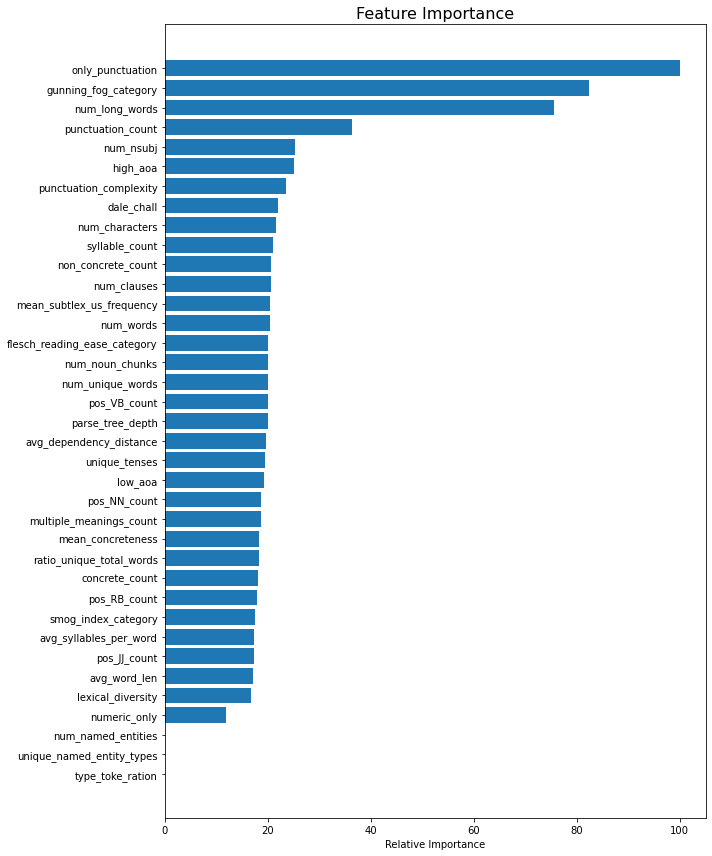

In [35]:
feature_importance = clf.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.figure(figsize=(10, 12))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(X.columns)[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Feature Importance',fontsize=16)
plt.tight_layout()
plt.savefig('relative_feat_importance.jpg', dpi=300)
plt.show()

In [8]:
text_characteristics = ['num_words', 'num_characters', 'num_unique_words', 'ratio_unique_total_words',
                        'num_long_words', 'avg_word_len', 'lexical_diversity', 'type_toke_ration']

linguistic_complexity = ['syllable_count', 'avg_syllables_per_word', 'multiple_meanings_count', 'parse_tree_depth',
                         'num_clauses', 'num_noun_chunks', 'avg_dependency_distance', 'punctuation_complexity',
                         'unique_tenses']

pos_counts = ['pos_NN_count', 'pos_VB_count', 'pos_JJ_count', 'pos_RB_count', 'num_nsubj']

named_entities = ['num_named_entities', 'unique_named_entity_types']

readability_metrics = ['flesch_reading_ease_category', 'gunning_fog_category', 'smog_index_category', 'dale_chall']

word_categories_complexity = ['high_aoa', 'low_aoa', 'concrete_count', 'non_concrete_count',
                              'mean_concreteness', 'mean_subtlex_us_frequency']

punctuation = ['only_punctuation', 'punctuation_count']

feature_categories = [text_characteristics, linguistic_complexity, pos_counts, named_entities, 
                      readability_metrics, word_categories_complexity, punctuation]


In [ ]:
from sklearn.model_selection import ShuffleSplit

N_SPLITS = 5  # Number of train/test splits
cv = ShuffleSplit(n_splits=N_SPLITS, test_size=0.2, random_state=42)

scores_per_category = [[] for _ in feature_categories]  # Initialize empty lists for scores
split= 0 
for train_index, test_index in cv.split(X, y):
    print(split)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    
    pipeline.fit(X_train, y_train)
    full_model_score = f1_score(y_test, pipeline.predict(X_test), average='macro')
    
    for i, category in enumerate(feature_categories):
        X_train_reduced = X_train.drop(category, axis=1)
        X_test_reduced = X_test.drop(category, axis=1)
        
        pipeline.fit(X_train_reduced, y_train)
        reduced_model_score = f1_score(y_test, pipeline.predict(X_test_reduced), average='macro')
        score_reduction = full_model_score - reduced_model_score
        
        scores_per_category[i].append(score_reduction)
    split+=1
# Plot box and whisker for each category
plt.boxplot(scores_per_category, vert=False)
plt.yticks(range(1, len(feature_categories)+1), ['Category ' + str(i+1) for i in range(len(feature_categories))])
plt.xlabel('Score reduction')
plt.title('Feature Ablation')
plt.savefig('feat_abblation.png', dpi=300)
plt.show()


0
1


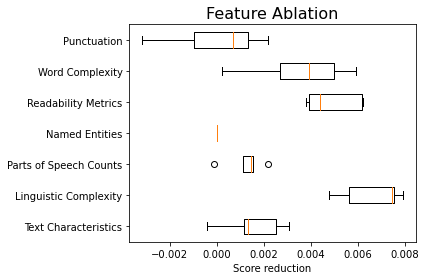

In [29]:
# Plot box and whisker for each category
plt.boxplot(scores_per_category, vert=False)

# Get the names of variables to be used as labels
category_names = ['Text Characteristics', 'Linguistic Complexity', 'Parts of Speech Counts', 'Named Entities', 
                  'Readability Metrics', 'Word Complexity', 'Punctuation']

# Set the names as y-tick labels
plt.yticks(range(1, len(category_names)+1), category_names)

plt.xlabel('Score reduction')
plt.title('Feature Ablation', fontsize=16,y=1.0)
#plt.suptitle('(Calculated with 5 iterations of 5-fold validation)', fontsize=10)
plt.tight_layout()
plt.savefig('feat_abblation.jpg', dpi=300)
plt.show()


# Plotting 2d and 3d

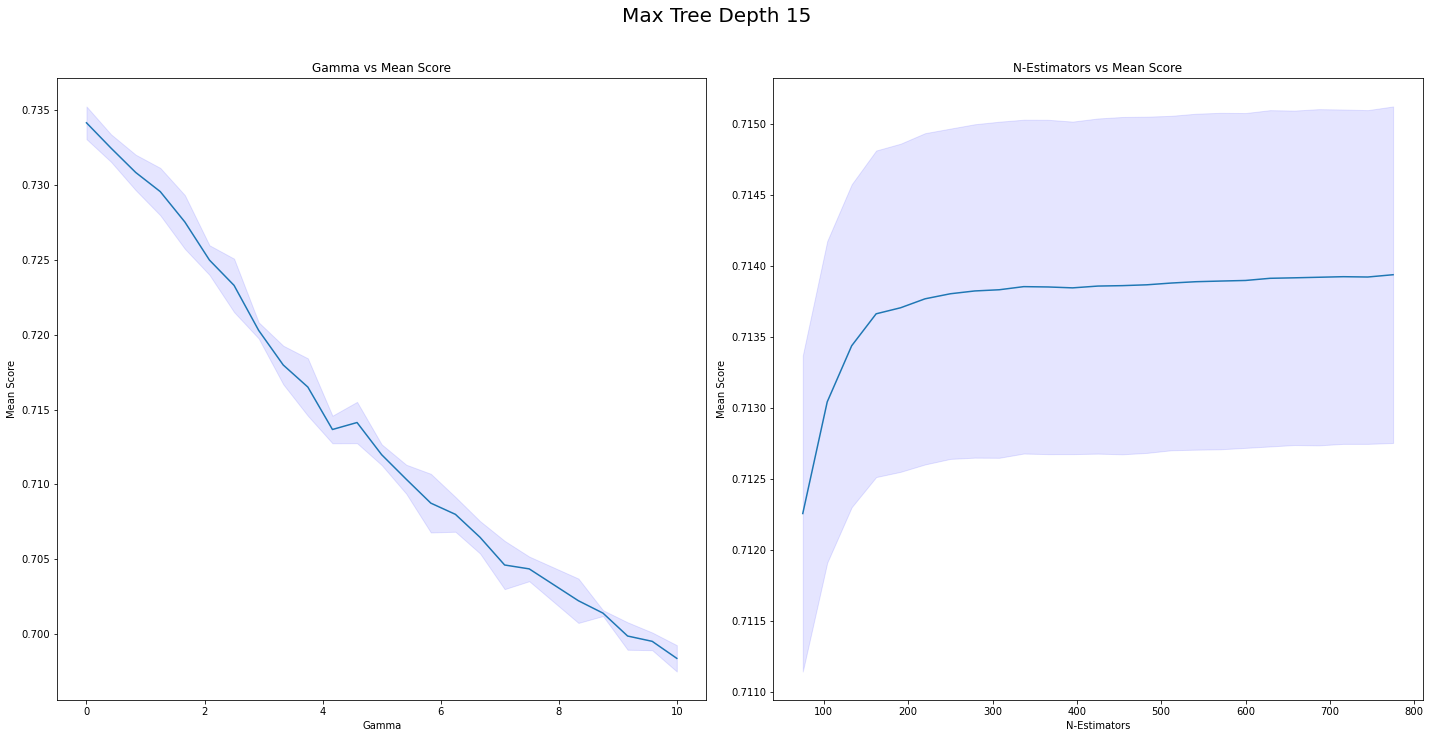

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Aggregate data by 'gamma' and 'n_estimator', calculating mean and standard error
grouped_gamma = results_df.groupby('gamma').agg({'mean_score': 'mean', 'standard_error': 'mean'}).reset_index()
grouped_n_estimator = results_df.groupby('n_estimator').agg({'mean_score': 'mean', 'standard_error': 'mean'}).reset_index()

# Creating the figure and the axes
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Define confidence level for 95% confidence interval
confidence_level = 1.96 # for 95% confidence interval

# Creating the 'gamma' vs 'mean_score' plot
sns.lineplot(x='gamma', y='mean_score', data=grouped_gamma, ax=axs[0])
axs[0].fill_between(grouped_gamma['gamma'], 
                    (grouped_gamma['mean_score'] - confidence_level * grouped_gamma['standard_error']), 
                    (grouped_gamma['mean_score'] + confidence_level * grouped_gamma['standard_error']), 
                    color='b', alpha=0.1)

axs[0].set_title('Gamma vs Mean Score')
axs[0].set_xlabel('Gamma')
axs[0].set_ylabel('Mean Score')


# Creating the 'n_estimator' vs 'mean_score' plot
sns.lineplot(x='n_estimator', y='mean_score', data=grouped_n_estimator, ax=axs[1])
axs[1].fill_between(grouped_n_estimator['n_estimator'], 
                    (grouped_n_estimator['mean_score'] - confidence_level * grouped_n_estimator['standard_error']), 
                    (grouped_n_estimator['mean_score'] + confidence_level * grouped_n_estimator['standard_error']), 
                    color='b', alpha=0.1)

axs[1].set_title('N-Estimators vs Mean Score')
axs[1].set_xlabel('N-Estimators')
axs[1].set_ylabel('Mean Score')

# Add a subtitle for the whole chart
plt.suptitle('Max Tree Depth 15', fontsize=20, y=1.02)

plt.tight_layout()
plt.savefig('2d_depth15.jpg', dpi=300)
plt.show()

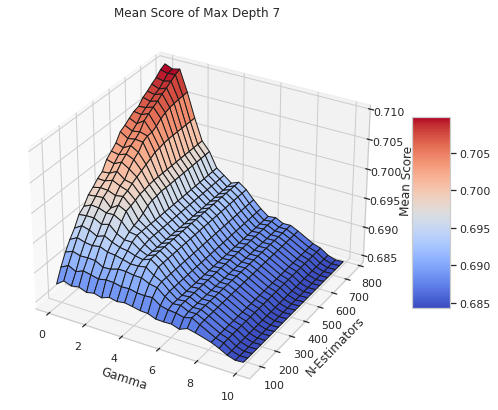

In [65]:

from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

# Create a pivot table for mean_score
pivot_table = pd.pivot_table(results_df, values='mean_score', index='n_estimator', columns='gamma')

# Create a grid from the pivot table index and columns
X, Y = np.meshgrid(pivot_table.columns, pivot_table.index)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Create the surface plot
surf = ax.plot_surface(X, Y, pivot_table.values, cmap='coolwarm', edgecolor='k')

# Add a color bar which maps values to colors
fig.colorbar(surf, ax=ax, shrink=0.5, aspect=5)
ax.set_xlabel('Gamma')
ax.set_ylabel('N-Estimators')
ax.set_zlabel('Mean Score')
ax.set_title('Mean Score of Max Depth 7')

fig.subplots_adjust(right=0.8)


#plt.tight_layout()
plt.savefig('3d_depth7.jpg', dpi=300)
plt.show()


# Code for sensititvy analysis 

In [ ]:
# Define the hyperparameters to search
gammas = np.linspace(0, 10, 25)  # Gamma values
n_estimators = np.linspace(75, 775, 25, dtype=int)  # Number of trees in the model
max_depth = 15

# Metrics
scorer = make_scorer(f1_score, average='macro')

# Store the results
results = []

# Perform cross-validation for each hyperparameter combination
def tune_parameters(gamma, n_estimator):
    scaler = StandardScaler()
    clf = XGBClassifier(gamma=gamma, n_estimators=n_estimator, max_depth=max_depth, eval_metric="logloss")
    pipeline = Pipeline([('scaler', scaler), ('classifier', clf)])
    cv_scores = cross_val_score(clf, X, y, cv=StratifiedKFold(n_splits=5), scoring=scorer)

#     # Calculate mean and standard deviation of the cross-validation scores
#     mean_score = np.mean(cv_scores)
#     std_score = np.std(cv_scores) / np.sqrt(len(cv_scores))  # Standard Error
    return {'gamma': gamma, 'n_estimator': n_estimator, 'mean_score': 0, 'std_score': 0, 'cv_scores':cv_scores}

with joblib.Parallel(n_jobs=-1) as parallel:
    for gamma in gammas:
        print(gamma)
        #need to get results from 2.92 and 0.83 pkl files to append
        if gamma <2.0:
            pass
        else:
            gamma_results = parallel(joblib.delayed(tune_parameters)(gamma, n_estimator) for n_estimator in n_estimators)
            results.extend(gamma_results)

            # Convert results to DataFrame and save after each gamma iteration
            results_df = pd.DataFrame(results)
            print('dumping results')
            with open(f'results15_gamma_{gamma:.2f}.pkl', 'wb') as f:
                pickle.dump(results_df, f)

# Save the final results as a DataFrame
results_df = pd.DataFrame(results)
results_df.to_pickle('results.pkl')

0.0
0.4166666666666667
0.8333333333333334
1.25
1.6666666666666667
2.0833333333333335


In [120]:
# results15_df['mean_score'] = results15_df['cv_scores'].apply(np.mean)
# results15_df['standard_error'] = results15_df['cv_scores'].apply(lambda x: np.std(x) / np.sqrt(len(x)))

In [49]:
# results7_df['mean_score'] = results7_df['cv_scores'].apply(np.mean)
# results7_df['standard_error'] = results7_df['cv_scores'].apply(lambda x: np.std(x) / np.sqrt(len(x)))